In [143]:
import numpy as np 
from scipy.integrate import odeint
import os, sys, warnings
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import utility as ut
import surrogate_nn as srnn
import surrogate1 as sr1
import surrogate as sr
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from scipy import stats
import hr_restrict as hrr
import time
from torch.autograd.functional import jacobian
from torchdiffeq import odeint as odeint
warnings.filterwarnings('ignore')

In [158]:
repo = '..'
save_folder = '{}/data/eigenvalues'.format(repo)
D, D_r = 3, 300
Lyapunov_time, dt = 1./.91, 0.02
error_threshold = 0.05
beta = 4e-5
L0, L1 = 0.4, 3.5
percents = 50
n_models = 600 * percents
row_selection = 'good_50_50'
train_option = 'random_20000'
N = 20000
L63_data_folder = '{}/data/L63-trajectories'.format(repo)
train = np.load('{}/train.npy'.format(L63_data_folder))
test = torch.from_numpy(np.load('{}/test.npy'.format(L63_data_folder)))
x0 = test[0, :, 0]
sampler = hrr.GoodRowSampler(L0, L1, train)
# random feature map
Wb = sampler.sample(D_r)
rf = sr.SurrogateModel_LR(D=3, D_r=300, W_in_fn=Wb[:, :-1], b_in_fn=Wb[:, -1])
rf.compute_W(train[:N], beta)
rf_psi = rf.get_tensor_map()
# neural network
network = srnn.SurrogateModel_NN(3, 300, save_folder='../data/nn_adaptive_lr_s')
network.load(1499000)
nn_psi = network.net
# The actual psi 
class L63(nn.Module):
    def __init__(self, dt):
        super(L63, self).__init__()
        self.t = torch.tensor([0., dt])
        
    def forward(self, t, u):
        x, y, z = u 
        p = 10. * (y - x)
        q = (28. - z) * x - y
        r = x * y - 8./3. * z
        return torch.stack([p, q, r], axis=-1)

l63 = L63(dt=dt)
def tr_psi(x):
    return odeint(l63, x, l63.t)[-1]
# eigenvalues for timeseries
def eseries(func, tseries):
    evals = torch.zeros((tseries.shape[0], D))
    for i, u in enumerate(tseries):
        evals[i] = torch.linalg.eigvals(jacobian(func, u))
    return evals
rf_psi(x0), nn_psi(x0), tr_psi(x0)

Time taken by sample is 0.0059 seconds


(tensor([15.1651, 15.7998, 35.4638]),
 tensor([15.1640, 15.8000, 35.4622], grad_fn=<SqueezeBackward4>),
 tensor([15.1651, 15.7999, 35.4622]))

In [159]:
trajectory_tr = test[0, :, :500].T
trajectory_rf = torch.from_numpy(rf.multistep_forecast(test[0, :, 0].numpy(), n_steps=trajectory_tr.shape[0]).T)
trajectory_nn = torch.from_numpy(network.multistep_forecast(test[0, :, 0].numpy(), n_steps=trajectory_tr.shape[0]).T)
rfe = eseries(rf_psi, trajectory_rf)
nne = eseries(nn_psi, trajectory_nn)
tre = eseries(tr_psi, trajectory_tr)

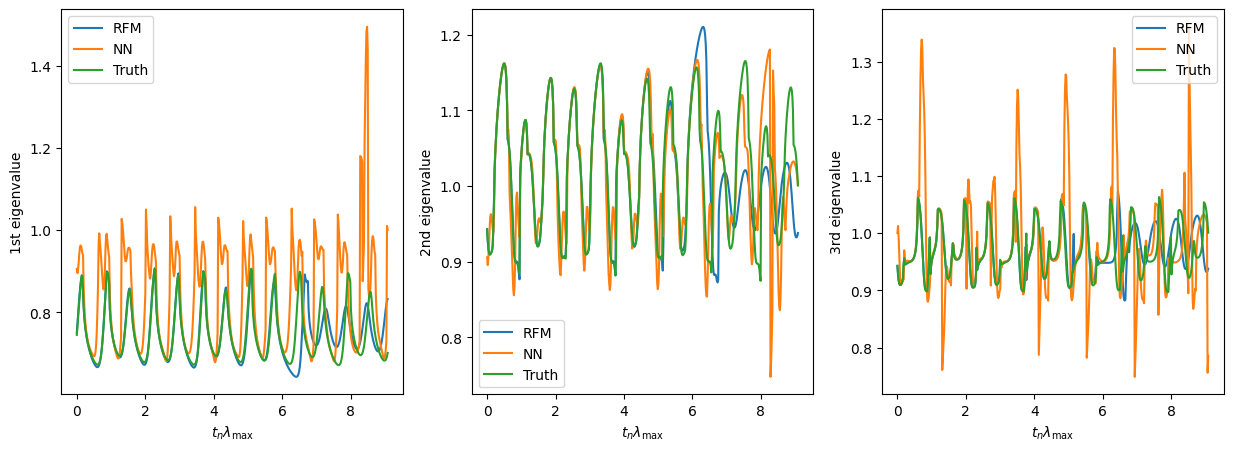

In [154]:
t = np.array(range(trajectory_tr.shape[0]))*dt*0.91
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.plot(t, rfe[:, 0], label='RFM')
ax1.plot(t, nne[:, 0], label='NN')
ax1.plot(t, tre[:, 0], label='Truth')
ax1.set_xlabel(r'$t_n\lambda_{\max}$')
ax1.set_ylabel('1st eigenvalue')
ax1.legend()

ax2.plot(t, rfe[:, 1], label='RFM')
ax2.plot(t, nne[:, 1], label='NN')
ax2.plot(t, tre[:, 1], label='Truth')
ax2.set_xlabel(r'$t_n\lambda_{\max}$')
ax2.set_ylabel('2nd eigenvalue')
ax2.legend()

ax3.plot(t, rfe[:, 2], label='RFM')
ax3.plot(t, nne[:, 2], label='NN')
ax3.plot(t, tre[:, 2], label='Truth')
ax3.set_xlabel(r'$t_n\lambda_{\max}$')
ax3.set_ylabel('3rd eigenvalue')
ax3.legend()

plt.savefig('../data/plots/eigenvalues.png', bbox_inches='tight')

In [169]:
trajectory_tr = torch.from_numpy(train.T)
trajectory_rf = torch.from_numpy(rf.multistep_forecast(trajectory_tr[0].numpy(), n_steps=100000).T)
trajectory_nn = torch.from_numpy(network.multistep_forecast(trajectory_tr[0].numpy(), n_steps=100000).T)

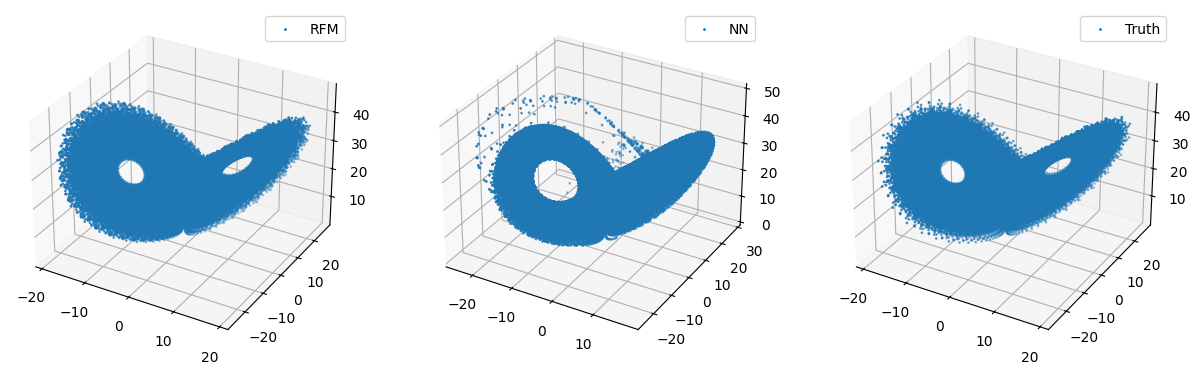

In [170]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')
N = 100000
ax1.scatter(trajectory_rf[:N, 0], trajectory_rf[:N, 1], trajectory_rf[:N, 2], label='RFM', s=1)
ax2.scatter(trajectory_nn[:N, 0], trajectory_nn[:N, 1], trajectory_nn[:N, 2], label='NN', s=1)
ax3.scatter(trajectory_tr[:N, 0], trajectory_tr[:N, 1], trajectory_tr[:N, 2], label='Truth', s=1)
# ax1.plot(t, tre[:, 0], label='Truth')
# ax1.set_xlabel(r'$t_n\lambda_{\max}$')
# ax1.set_ylabel('1st eigenvalue')
ax1.legend()

# ax2.plot(t, rfe[:, 1], label='RFM')
# ax2.plot(t, nne[:, 1], label='NN')
# ax2.plot(t, tre[:, 1], label='Truth')
# ax2.set_xlabel(r'$t_n\lambda_{\max}$')
# ax2.set_ylabel('2nd eigenvalue')
ax2.legend()

# ax3.plot(t, rfe[:, 2], label='RFM')
# ax3.plot(t, nne[:, 2], label='NN')
# ax3.plot(t, tre[:, 2], label='Truth')
# ax3.set_xlabel(r'$t_n\lambda_{\max}$')
# ax3.set_ylabel('3rd eigenvalue')
ax3.legend()

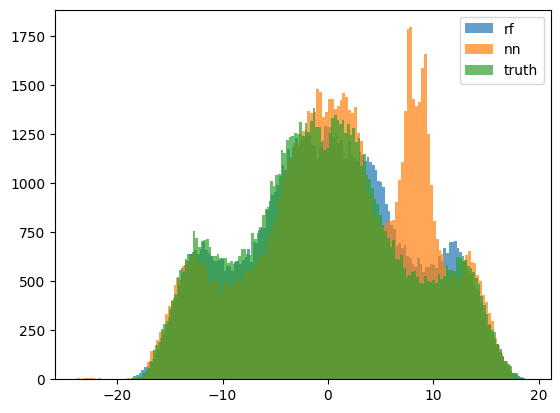

In [171]:
plt.hist(trajectory_rf[:N, 0], bins=150, alpha=0.7, label='rf')
plt.hist(trajectory_nn[:N, 0], bins=150, alpha=0.7, label='nn')
plt.hist(trajectory_tr[:N, 0], bins=150, alpha=0.7, label='truth')
plt.legend()

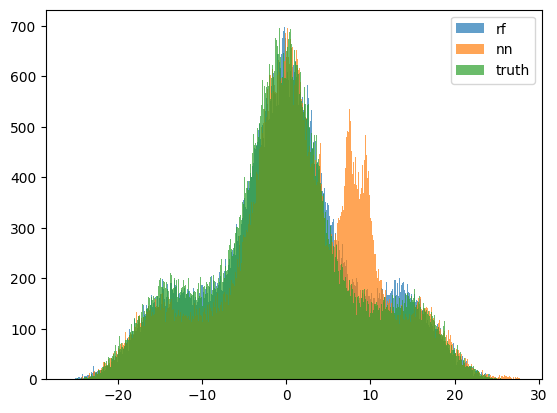

In [172]:
plt.hist(trajectory_rf[:N, 1], bins=500, alpha=0.7, label='rf')
plt.hist(trajectory_nn[:N, 1], bins=500, alpha=0.7, label='nn')
plt.hist(trajectory_tr[:N, 1], bins=500, alpha=0.7, label='truth')
plt.legend()

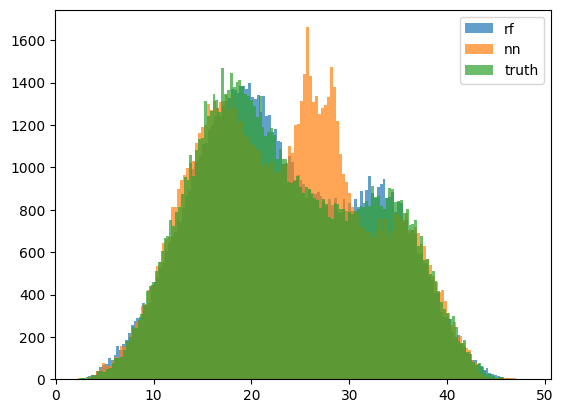

In [174]:
plt.hist(trajectory_rf[:N, 2], bins=150, alpha=0.7, label='rf')
plt.hist(trajectory_nn[:N, 2], bins=150, alpha=0.7, label='nn')
plt.hist(trajectory_tr[:N, 2], bins=150, alpha=0.7, label='truth')
plt.legend()

In [127]:
trajectory_tr.shape

torch.Size([800, 3])

In [139]:
trajectory_tr.shape

torch.Size([200000, 3])